In [1]:
import torch

from torch.optim import Adam

from functools import partial
# Visualization tools
import matplotlib.pyplot as plt

# User defined libraries
from utils.ddpm_utils import *
from utils import UNet_utils
from utils.other_utils import *
from utils.constraints import classifier_constraint, brightness_constraint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%matplotlib inline

c:\Users\thiag\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMG_SIZE = 28
IMG_CH = 1
BATCH_SIZE = 128
N_CLASSES = 10
data, dataloader = load_transformed_MNIST(IMG_SIZE, BATCH_SIZE)
ncols = 5
timesteps = 500
scheduler = CosineScheduler(timesteps=timesteps, device=device)

In [3]:
# model = UNet_utils.UNet(
#     timesteps, IMG_CH, IMG_SIZE, down_chs=(64, 64, 128), t_embed_dim=8, c_embed_dim=0
# )
model = UNet_utils.UNet2DWrapper()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model.to(device)

trainer = DDPMTrainer(scheduler=scheduler, device=device)
ddpm_sampler = DDPMSampler(
    scheduler=scheduler, device=device, img_ch=IMG_CH, img_size=IMG_SIZE, ncols=ncols
)

Num params:  6138369


Epoch 3/4: 100%|██████████| 546/546 [01:44<00:00,  5.23it/s, loss=0.0257]


Epoch 4, Step: 100, Mean loss: 0.02980983752757311


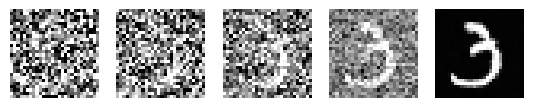

Epoch 4, Step: 200, Mean loss: 0.029494877140969038


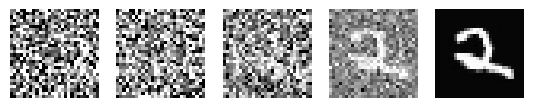

Epoch 4, Step: 300, Mean loss: 0.029480581153184176


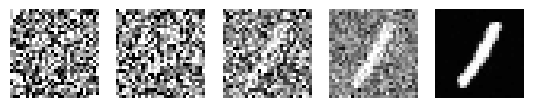

Epoch 4, Step: 400, Mean loss: 0.02891339162364602


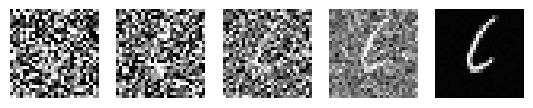

Epoch 4, Step: 500, Mean loss: 0.030245048105716706


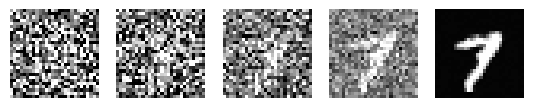

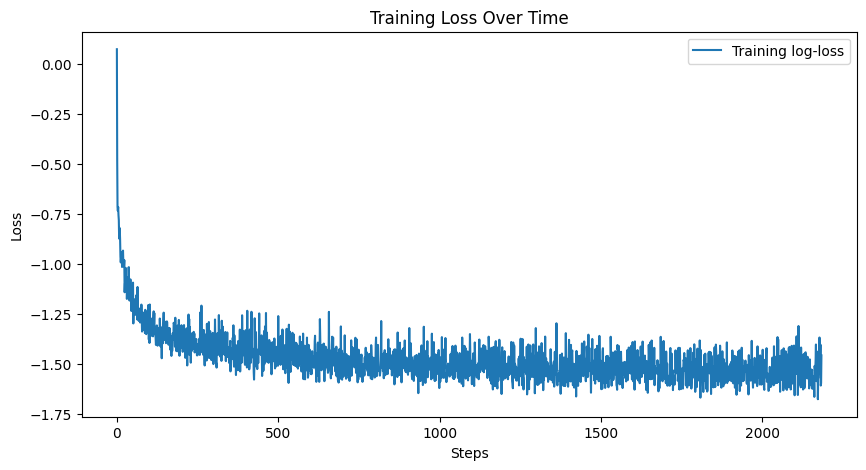

Epoch 4/4: 100%|██████████| 546/546 [01:44<00:00,  5.20it/s, loss=0.035]


In [4]:
num_epochs = 4
losses, model = trainer.train(
    model=model,
    dataloader=dataloader,
    num_epochs=num_epochs,
    sampler=ddpm_sampler,
    plot=True,
)
torch.save(model, "model.pkl")

In [3]:
model = torch.load('model.pkl')

C:\Users\thiag\AppData\Local\Temp\ipykernel_17824\869935722.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model.pkl')


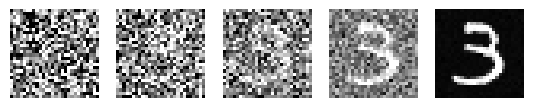

Mean brightness of the generated image: 0.1337


In [7]:
vpsde_sampler = VPSDESampler(
    scheduler=scheduler, device=device, img_ch=IMG_CH, img_size=IMG_SIZE, ncols=ncols
)

img = vpsde_sampler.sample_images(model=model)
img = torch.clamp(img, 0, 1)
img = img.view(img.size(0), -1)
mean_brightness = img.mean()

print(f"Mean brightness of the generated image: {mean_brightness.item():.4f}")

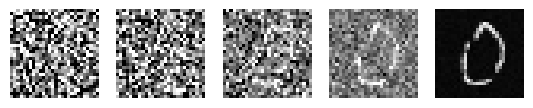

Mean brightness of the generated image: 0.0585


In [49]:
gfuncs = [partial(brightness_constraint, target=0.05, tol=0.001)]
lmc_steps: int = 5
step_size: float = 0.85
step_size_lambda: float = 0.15

pdlmc_sampler = PDLMCSampler(
    scheduler=scheduler,
    device=device,
    img_ch=IMG_CH,
    img_size=IMG_SIZE,
    ncols=ncols,
    gfuncs=gfuncs,
    lmc_steps=lmc_steps,
    step_size=step_size,
    step_size_lambda=step_size_lambda,
)

img = pdlmc_sampler.sample_images(model=model)
img = torch.clamp(img, 0, 1)
img = img.view(img.size(0), -1)
mean_brightness = img.mean()

print(f"Mean brightness of the generated image: {mean_brightness.item():.4f}")